In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torchinfo import summary

from utils import (load_all_data, 
                   squeeze_and_concat, 
                   filter_mask_keep_labels, 
                   multiclass_dice_loss, 
                   check_gradients)
from datasets import MultiTissueDataset
from unet_advanced import UNetAdvanced as UNetGan
from gan_basic import DiscriminatorModel
from train_utils import EarlyStopping

%load_ext autoreload
%autoreload 2


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left
data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

In [4]:
val_fraction = 0.2

num_samples = len(data_concat['input_labels'])
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_indices = indices[:int(num_samples*(1-val_fraction))]
val_indices = indices[int(num_samples*(1-val_fraction)):]

In [5]:
train_data = {key: value[train_indices] for key, value in data_concat.items()}
val_data = {key: value[val_indices] for key, value in data_concat.items()}

In [6]:
train_dataset = MultiTissueDataset(train_data)
val_dataset = MultiTissueDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [8]:
def train_discriminator(batch, gen, discr, criterion_GAN, optim_discr, device='cpu'):
    input = batch['input_label'].to(device) # Models passed to the function should be already on the same device
    gt = batch['multiClassMask'].to(device)

    # train discriminator
    with torch.no_grad():
        gen_img_probs = gen(input).softmax(dim=1)  # Get probabilities for each class

    gt_onehot = torch.zeros_like(gen_img_probs).scatter_(1, gt.unsqueeze(1), 1.0) # Assigns 1.0 in the corresponding class channel based on gt indices (0-11)

    discr_input_real = torch.cat([input, gt_onehot], dim=1)  # Real pairs: input + gt
    discr_input_fake = torch.cat([input, gen_img_probs], dim=1)  # Fake pairs: input + generated segmentation (probs)

    discr_real = discr(discr_input_real) # Discrim forward pass on real pairs
    discr_fake = discr(discr_input_fake) # Discrim forward pass on fake pairs

    loss = criterion_GAN(discr_real, torch.ones_like(discr_real)) + \
        criterion_GAN(discr_fake, torch.zeros_like(discr_fake))

    optim_discr.zero_grad()
    loss.backward()
    optim_discr.step()

    return loss.item()

def train_generator(batch, gen, discr, criterion_GAN, criterion_CE, optim_gen, lambda_ce, device='cpu'):
    input = batch['input_label'].to(device)
    gt = batch['multiClassMask'].to(device)
    
    gen_img = gen(input)
    gen_img_probs = gen_img.softmax(dim=1)  # Now with gradients enablesd for generator training

    discr_input_fake = torch.cat([input, gen_img_probs], dim=1)  # Fake pairs: input + generated segmentation (probs)
    discr_fake = discr(discr_input_fake) # Discrim forward pass on fake pairs


    ce_loss = criterion_CE(gen_img, gt)  # CE loss between generated segmentation and ground truth (B, 12, H, W)
    loss_gen = criterion_GAN(discr_fake, torch.ones_like(discr_fake)) + lambda_ce * ce_loss

    optim_gen.zero_grad()
    loss_gen.backward()
    optim_gen.step()

    return loss_gen.item(), ce_loss.item()

def validate_generator(val_dataloader, gen, discr, criterion_GAN, criterion_CE, lambda_ce, device='cpu'):
    gen.eval()
    discr.eval()

    total_gan_loss = 0.0
    total_ce_loss = 0.0
    total_dice_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input = batch['input_label'].to(device)
            gt = batch['multiClassMask'].to(device)

            gen_img = gen(input)
            gen_img_probs = gen_img.softmax(dim=1)

            discr_input_fake = torch.cat([input, gen_img_probs], dim=1)
            discr_fake = discr(discr_input_fake)

            # Compute losses
            ce_loss = criterion_CE(gen_img, gt)
            gan_loss = criterion_GAN(discr_fake, torch.ones_like(discr_fake))
            dice_loss = multiclass_dice_loss(gen_img, gt) # Logits here as input

            total_gan_loss += gan_loss.item()
            total_ce_loss += ce_loss.item()
            total_dice_loss += dice_loss.item()
            num_batches += 1

    avg_gan_loss = total_gan_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_dice_loss = total_dice_loss / num_batches

    return avg_gan_loss, avg_ce_loss, avg_dice_loss


In [9]:
def train_gan(num_steps, n_discr_steps, gen, discr, dataloader, criterion_GAN, criterion_CE, optim_gen, optim_discr, lambda_l1, device):
    inf_iter = cycle(dataloader)
    pbar = tqdm(range(num_steps), desc="Training step")
    
    metrics_history = {
        'D_loss': [],
        'G_loss': [],
        'CE_loss': []
    }

    for step in pbar:
        batch = next(inf_iter)

        gen.train()
        discr.train()

        loss_discr = 0.0
        for _ in range(n_discr_steps): # Nested loop to allow multiple discriminator updates per generator update
            running_loss_discr = train_discriminator(batch, gen, discr, criterion_GAN, optim_discr, device)
            loss_discr += running_loss_discr
        loss_discr /= n_discr_steps
    
        loss_gen, ce_loss = train_generator(batch, gen, discr, criterion_GAN, criterion_CE, optim_gen, lambda_l1, device)
        
        if step % 20 == 0: # Update progress bar every 20 steps
            pbar.set_postfix({
                'D_loss': f'{loss_discr:.4f}', 
                'G_loss': f'{loss_gen:.4f}',
                'CE': f'{ce_loss:.4f}'
            })

        metrics_history['D_loss'].append(loss_discr)
        metrics_history['G_loss'].append(loss_gen)
        metrics_history['CE_loss'].append(ce_loss)

        # check for early stopping based on validation dice score
        
    return metrics_history

        

In [10]:
num_steps = 50
n_discr_steps = 1
lambda_l1 = 1.0

gen = UNetGan(in_ch=4, num_classes=12, dropout_p=0.3).to(device)
discr = DiscriminatorModel(in_ch=16, base_ch=64).to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_CE = nn.CrossEntropyLoss() # CE loss for segmentation (better than L1 for classification tasks)

optim_gen = optim.Adam(gen.parameters(), lr=1e-4)
optim_discr = optim.Adam(discr.parameters(), lr=1e-4)

In [11]:
history = train_gan(num_steps, n_discr_steps, gen, discr, train_dataloader, criterion_GAN, criterion_CE, optim_gen, optim_discr, lambda_l1, device)

Training step: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s, D_loss=0.9349, G_loss=2.2922, CE=1.3673]


In [12]:
losses = validate_generator(val_dataloader, gen, discr, criterion_GAN, criterion_CE, lambda_l1, device)

In [14]:
# check on generated images
with torch.no_grad():
    val_batch = next(iter(val_dataloader))
    input = val_batch['input_label'].to(device)
    gt = val_batch['multiClassMask'].to(device)
    gen_img = gen(input)



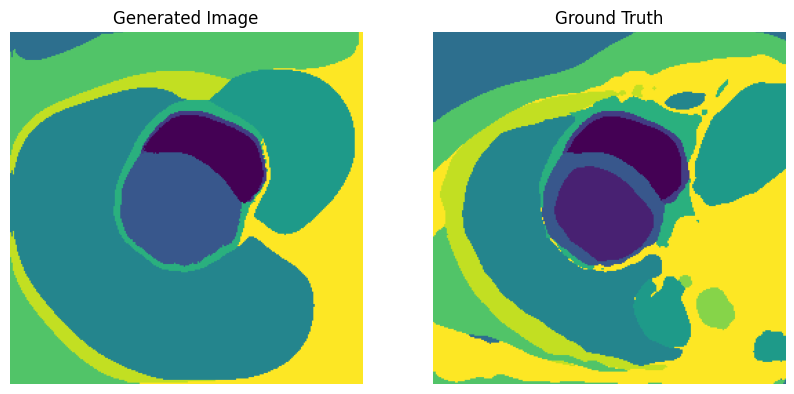

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(torch.argmax(gen_img[0], dim=0).cpu())
ax[0].set_title("Generated Image")
ax[0].axis("off")

ax[1].imshow(gt[0].cpu())
ax[1].set_title("Ground Truth")
ax[1].axis("off")

plt.show()